<a href="https://colab.research.google.com/github/jakeval/MRMC/blob/main/MIM_Adult.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MIM on the Adult Dataset

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot as plt
from matplotlib import cm as cm
import math
import csv

## Data Utilities

### Data Setup

In [ ]:
def clean_data(df, category_columns, binary_columns, le_dict=None):
  df = df.drop(columns=['education']) # education is redundant
  df = df.drop(columns=['native-country'])
  df = df.drop(columns=['fnlwgt'])
  df = df.drop_duplicates()

  # drop rows with missing values
  for c in category_columns:
    df = df.drop(index=df[df[c] == '?'].index)

  df = pd.get_dummies(df, prefix=category_columns, columns=category_columns)

  le_new = {}
  for column in binary_columns:
    le = None
    if le_dict is None:
      le = LabelEncoder()
      le.fit(df[column])
    else:
      le = le_dict[column]
    le_new[column] = le
    encoded_data = le.transform(df[column])
    df[column] = encoded_data

  return df, le_new

def normalize_data(df):
  mean = df.mean()
  std = df.std()

  return (df - mean)/std, mean, std

def load_data():
  column_names = "age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income".split(',')
  reformat_data('adult.data', 'adult_reformatted.data', column_names)
  reformat_data('adult.test', 'adult_reformatted.test', column_names, is_test=True)

  df = None
  with open('adult_reformatted.data') as f:
    df = pd.read_csv(f)

  df_test = None
  with open('adult_reformatted.test') as f:
    df_test = pd.read_csv(f)

  category_columns = ['workclass', 'marital-status', 'occupation', 'relationship', 'race']
  binary_columns = ['sex', 'income']

  # Prepare training data
  df_cleaned, le = clean_data(df, category_columns, binary_columns)
  df_cleaned['income'] = df_cleaned['income'] * 2 - 1

  df_X = df_cleaned.loc[:, df_cleaned.columns != 'income']
  df_Y = df_cleaned['income']

  df_X, mean, std = normalize_data(df_X)

  # Prepare testing data
  df_test_clean, le = clean_data(df_test, category_columns, binary_columns, le_dict=le)
  df_test_X = df_test_clean.loc[:,df_test_clean.columns != 'income']
  df_test_Y = df_test_clean['income']

  df_test_X = (df_test_X - mean) / std
  df_test_Y = df_test_Y * 2 - 1

  return df_X, df_Y, df_test_X, df_test_Y, le

### Get Random POI

In [ ]:
"""def sample_data(df, N, ratio=0.5):
  pos_N = int(N*ratio)
  neg_N = int(N*(1-ratio))

  pos_samples = df[df['income'] == 1].sample(pos_N)
  neg_samples = df[df['income'] == -1].sample(neg_N)

  df_sampled = pd.concat([pos_samples, neg_samples])
  df_X = df_sampled.loc[:, df_sampled.columns != 'income']
  df_Y = df_sampled['income']
  return df_X, df_Y"""

def random_poi(X, Y, y):
  matching_Xs = Y == y
  cs = matching_Xs.cumsum()
  matching_i = np.random.randint(X[Y == y].shape[0])
  i = np.where(cs == matching_i+1)[0][0]
  return X[i], np.delete(X, i, axis=0), np.delete(Y, i, axis=0)

def random_poi_df(df_X, df_Y, y):
  poi = df_X[df_Y == y].sample(1)
  df_X = df_X.drop(labels=poi.index, axis=0)
  df_Y = df_Y.drop(labels=poi.index, axis=0)
  return poi, df_X, df_Y

### Data Filtering

In [ ]:
def filter_accuracy(df_X, df_Y, model, certainty_cutoff=0.7):
  predictions = rf.predict_proba(df_X)
  Y_indices = ((df_Y + 1)/2).astype(np.int)
  correct_proba = np.where(Y_indices, predictions[:,1], predictions[:,0]) # the probability that the model matches Y
  accurate_idx = correct_proba >= certainty_cutoff
  return df_X[accurate_idx], df_Y[accurate_idx]

def get_actionability_filter(df_X, immutable_columns, column_tolerances):
  immutable_idx, column_dict = immutable_indices(df_X, immutable_columns)
  tolerance_dict = {}
  for column, tol in column_tolerances.items():
    for idx in column_dict[column]:
      tolerance_dict[idx] = tol

  def actionability_filter(X, Y, poi):
    return filter_actionability(X, Y, poi, immutable_idx, tolerance_dict)
  
  return actionability_filter

def filter_actionability(X, Y, poi, immutable_idx, tolerance_dict):
  Xfiltered, Yfiltered = X, Y
  for idx in immutable_idx:
    mask = None
    if idx in tolerance_dict:
      tol = tolerance_dict[idx]
      mask = (np.abs(Xfiltered[:,idx] - poi[idx]) <= tol)
    else:
      mask = (Xfiltered[:,idx] == poi[idx])
    Xfiltered = Xfiltered[mask]
    Yfiltered = Yfiltered[mask]
  return Xfiltered, Yfiltered

def make_immutable_dist(df_X, immutable_columns, mask_value):
  idx, _ = immutable_indices(df_X, immutable_columns)
  mask = np.ones(df_X.shape[1])
  mask[idx] = mask_value

  def dist(X, poi):
    return (X - poi)*mask

  return dist

def immutable_indices(df, immutable_columns):
  indices = []
  column_dict = dict([(feature, []) for feature in immutable_columns])
  for i, column in enumerate(df.columns):
    feature = column
    if is_dummy(column):
      feature, category = decode_ohe(column)
    if feature in immutable_columns:
      indices.append(i)
      column_dict[feature].append(i)
  return np.array(indices), column_dict

def immutable_columns_full(df, immutable_features):
  full_columns = []
  for i, column in enumerate(df.columns):
    feature = column
    if is_dummy(column):
      feature, category = decode_ohe(column)
    if feature in immutable_columns:
      full_columns.append(column)
  return full_columns

def is_dummy(column):
  return "_" in column

def decode_ohe(column_name):
  return column_name.split('_')

## Visualization Utilities

In [ ]:
def display_scatter(X, Y, poi_paths=None, clusters=None, title=None, center=None, border=None, do_pca=False, size=None, alpha=1):
  if do_pca:
    pca = PCA(2)
    pca.fit(X)
    X = pca.transform(X)
    if poi_paths is not None:
      poi_paths_pca = []
      for i, poi_path in enumerate(poi_paths):
        poi_paths_pca.append(pca.transform(poi_path))
      poi_paths = poi_paths_pca
    if clusters is not None:
      clusters = pca.transform(clusters)

  A = X[Y == 1]
  B = X[Y == -1]
  fig, ax = None, None
  if size is None:
    fig, ax = plt.subplots()
  else:
    fig, ax = plt.subplots(figsize=(15,12))
  ax.scatter(A[:,0], A[:,1], alpha=alpha, label=">50K (1)")
  ax.scatter(B[:,0], B[:,1], alpha=alpha, label="<=50K (-1)")
  if poi_paths is not None:
    ax.scatter([poi_paths[0][0,0]], [poi_paths[0][0,1]], label="POI origin")
    for i, poi_path in enumerate(poi_paths):
      ax.plot(poi_path[:,0], poi_path[:,1])
      ax.scatter(poi_path[1:,0], poi_path[1:,1], label=f"POI Path {i}")
  if clusters is not None:
    ax.scatter(clusters[:,0], clusters[:,1], label="Cluster Centers")
  if title:
    ax.set_title(title)
  if center is not None:
    ax.set_xlim([center[0]-border, center[0]+border])
    ax.set_ylim([center[1]-border, center[1]+border])
  ax.legend()
  plt.show()
  plt.close()

def display_heatmap(X, Y, poi_paths=None, clusters=None, title=None, center=None, border=None, do_pca=False, size=None):
  if do_pca:
    pca = PCA(2)
    pca.fit(X)
    X = pca.transform(X)
    if poi_paths is not None:
      poi_paths_pca = []
      for i, poi_path in enumerate(poi_paths):
        poi_paths_pca.append(pca.transform(poi_path))
      poi_paths = poi_paths_pca
    if clusters is not None:
      clusters = pca.transform(clusters)
  fig, ax = None, None
  if size is None:
    fig, ax = plt.subplots()
  else:
    fig, ax = plt.subplots(figsize=(15,12))
  ax.hexbin(X[:,0], X[:,1], C=Y, gridsize=60, bins=None)
  if poi_paths is not None:
    ax.scatter([poi_paths[0][0,0]], [poi_paths[0][0,1]], label="POI origin")
    for i, poi_path in enumerate(poi_paths):
      ax.plot(poi_path[:,0], poi_path[:,1])
      ax.scatter(poi_path[1:,0], poi_path[1:,1], label=f"POI Path {i}")
  if clusters is not None:
    ax.scatter(clusters[:,0], clusters[:,1], label="Cluster Centers", marker='x', c='fuchsia')
    for i, cluster in enumerate(clusters):
      ax.annotate(f"Cluster {i}", cluster)
  if title:
    ax.set_title(title)
  if center is not None:
    ax.set_xlim([center[0]-border, center[0]+border])
    ax.set_ylim([center[1]-border, center[1]+border])
    
  
  cb = fig.colorbar(cm.ScalarMappable(), ax=ax)
  cb.set_label("Mean Label Value")
  ax.legend()
  plt.show()
  plt.close()

### PCA Example

In [ ]:
pca = PCA(n_components='mle')
pca.fit(df_X)

pca = PCA(2)
pca.fit(df_X)
X_pca = pca.transform(df_X)

display_scatter(X_pca[df_Y == 1], df_Y[df_Y == 1])
display_scatter(X_pca[df_Y == -1], df_Y[df_Y == -1])

display_heatmap(X_pca, df_Y)

## MRM Setup

### Relevant Utility Functions

In [ ]:
def explain_dirs(poi, next_points, columns, mean=None, std=None):
  for i, next_point in enumerate(next_points):
    print(f"Direction {i}")
    start = poi
    end = next_point
    if mean is not None:
      start = poi*std + mean
      end = next_point*std + mean
    for j in range(len(columns)):
      if poi[j] != next_point[j]:
        print(f"\tChange {columns[j]} from {start[j]} to {end[j]}")

def size_normalization(dir, X):
  return dir / X.shape[0]

def perturb_point(scale, x):
  perturbation = np.random.normal(loc=(0,0), scale=scale)
  return x + perturbation

def constant_priority_dir(dir, k=1, step_size=1):
  return constant_step_size(priority_dir(dir, k), step_size)

def priority_dir(dir, k=5):
  sorted_idx = np.argsort(-np.abs(dir))  
  dir_new = np.zeros_like(dir)
  dir_new[sorted_idx[:k]] = dir[sorted_idx[:k]]
  return dir_new

def constant_step_size(dir, step_size=1):
  return step_size*dir / np.sqrt(dir@dir)

def preference_dir(preferences, epsilon, max_step_size, dir):
  for dimension in preferences:
    if np.abs(dir[dimension]) > epsilon:
      perturbed_dir = np.zeros_like(dir)
      perturbed_dir[dimension] = min(dir[dimension], max_step_size)
      return perturbed_dir
  return np.zeros_like(dir)

def volcano_alpha(u, sigma_close, sigma_far, scale, dist):
  close_val = np.exp(-0.5 * ((dist - u)/sigma_close)**2)
  far_val = np.exp(-0.5 * ((dist - u)/sigma_far)**2)
  return scale * np.where(dist < u, close_val, far_val)

def cliff_alpha(dist, cutoff=0.5, degree=2):
  return np.where(dist <= cutoff, 1/cutoff**degree, 1/dist**degree)

### Basic MRM

In [ ]:
class MRM:
  def __init__(self, alpha=cliff_alpha, alpha_neg=None, ignore_negatives=True, difference_function=None, weight_function=size_normalization):
    self.alpha = alpha
    self.alpha_neg = alpha_neg
    self.ignore_negatives = ignore_negatives
    self.difference_function = difference_function
    if difference_function is None:
      self.difference_function = lambda X, poi: X - poi
    self.weight_function = weight_function
    if weight_function is None:
      self.weight_function = lambda dir, X: dir
    self.X = None
    self.Y = None

  def fit(self, X, Y):
    if self.ignore_negatives:
      self.X = X[Y == 1]
      self.Y = Y[Y == 1]
    else:
      self.X = X
      self.Y = Y

  def transform(self, poi):
    if self.X[self.Y == 1].shape[0] == 0:
      raise Exception("After filtering, all positive examples have been removed.")
    indicator = (self.Y == 1) * 2 - 1
    diff = self.difference_function(self.X, poi)
    dist = np.sqrt(np.power(diff, 2).sum(axis=1))
    alpha_val = self.alpha(dist)
    if self.alpha_neg is not None:
      alpha_val = np.where(indicator == 1, self.alpha(dist), self.alpha_neg(dist))
    dir = diff.T@(alpha_val * indicator)
    return self.weight_function(dir, self.X)

  def set_difference_function(self, difference_function):
    self.difference_function = difference_function

### Iterated MRM and MRMC

In [ ]:
class MRMIterator:
  def __init__(self, mrm, max_iterations=100, perturb_dir=constant_priority_dir, early_stopping=None):
    self.mrm = mrm
    self.perturb_dir = perturb_dir
    if perturb_dir is None:
      self.perturb_dir = lambda dir: dir
    self.max_iterations=max_iterations
    self.dimensions = None
    self.early_stopping = early_stopping
    if self.early_stopping is None:
      self.early_stopping = lambda _: False

  def fit(self, X, Y):
    self.mrm.fit(X, Y)
    self.dimensions = X.shape[1]

  def iterate(self, poi):
    curr_poi = poi
    poi_path = np.empty(shape=(self.max_iterations, self.dimensions))
    i = 0
    while i < self.max_iterations:
      poi_path[i] = curr_poi
      dir = self.mrm.transform(curr_poi)
      if np.isnan(dir).any():
        # print(dir)
        # print(curr_poi)
        return(poi_path[:i])
      dir = self.perturb_dir(dir)
      curr_poi = curr_poi + dir
      i += 1
      if self.early_stopping(curr_poi):
        return poi_path[:i]
    return poi_path[:i]

class MRMCIterator(MRMIterator):
  def __init__(self, clusterer, k_dirs, *args, **kwargs):
    super().__init__(*args, **kwargs)
    self.cluster_centers_ = None
    self.cluster_assignments_ = None
    self.clusterer = clusterer
    self.k_dirs = k_dirs
    self.X = None
    self.Y = None

  def fit(self, X, Y):
    super().fit(X, Y)
    self.cluster_assignments_ = self.clusterer.predict(X[Y == 1])
    self.cluster_centers_ = self.clusterer.cluster_centers_
    self.X = X
    self.Y = Y
    
  def iterate(self, poi):
    paths = []
    for i, center in enumerate(self.cluster_centers_):
      X_cluster = self.X[self.Y == 1][self.cluster_assignments_ == i]
      Y_cluster = self.Y[self.Y == 1][self.cluster_assignments_ == i]
      X_full = np.concatenate([self.X[self.Y == -1], X_cluster])
      Y_full = np.concatenate([self.Y[self.Y == -1], Y_cluster])
      super().fit(X_full, Y_full)
      poi_path = super().iterate(poi)
      paths.append(poi_path)
    return paths

## MRMC Demonstrations

### Synthetic Data Demonstration

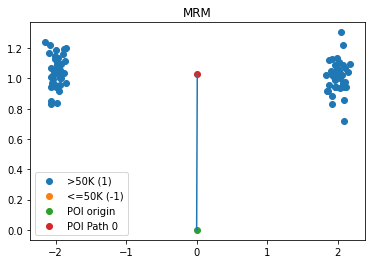

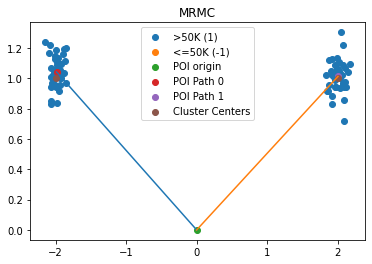

In [344]:
class Cluster:
  def __init__(self, loc, scale, freq, label):
    self.loc = loc
    self.scale = scale
    self.freq = freq
    self.label = label

def random_clusters(labels):
  clusters = []
  for label in labels:
    loc = np.random.normal(loc=(0,0), scale=(4,4), size=2)
    scale = np.abs(np.random.normal(loc=(1,1), scale=(4,4), size=2))
    freq = np.random.random()*2
    clusters.append(Cluster(loc, scale, freq, label))
  return clusters

def gen_data(clusters, N=10):
  D = 2
  X = np.empty(shape=(0,2))
  Y = np.empty(shape=(0,))
  for cluster in clusters:
    cluster_N = int(N*cluster.freq)
    cluster_X = np.random.normal(loc=cluster.loc, scale=cluster.scale, size=(cluster_N, D))
    X = np.concatenate([X, cluster_X])
    cluster_Y = None
    if cluster.label == 1:
      cluster_Y = np.ones(cluster_N)
    else:
      cluster_Y = np.ones(cluster_N) * -1
    Y = np.concatenate([Y, cluster_Y])
  return np.array(X), np.array(Y)


# Three well-separated clusters
N = 40
cluster1 = Cluster(loc=(-2,1), scale=(0.1, 0.1), freq=1, label=1)
cluster2 = Cluster(loc=(2,1), scale=(0.1, 0.1), freq=1, label=1)
X, Y = gen_data([cluster1, cluster2], N=N)

alpha_neg=lambda dist: 0
alpha = lambda dist: 1
perturb_dir = lambda dir: constant_step_size(0.2, dir)
perturb_dir = None

poi = np.array([0,0])
poi_path = iterated_mim(X, Y, poi, alpha, alpha_neg=alpha_neg, T=2, weighted=True, perturb_point=None, perturb_dir=perturb_dir)

display_scatter(X, Y, poi_path[None,:], title="MRM")

C = np.concatenate([np.zeros(N), np.ones(N)])
cluster_centers = np.array([[-2,1], [2,1]])
poi_paths = clustered_mim(X, Y, C, poi, cluster_centers, alpha, alpha_neg=alpha_neg, T=2, weighted=True, perturb_point=None, perturb_dir=perturb_dir)

display_scatter(X, Y, poi_paths, clusters=cluster_centers, title="MRMC")

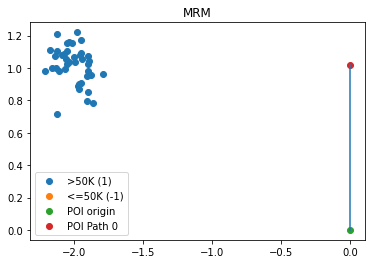

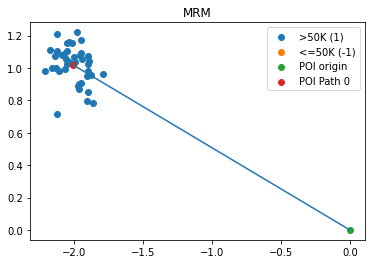

In [345]:
# Three well-separated clusters
N = 40
cluster1 = Cluster(loc=(-2,1), scale=(0.1, 0.1), freq=1, label=1)
cluster2 = Cluster(loc=(0,1), scale=(0.1, 0.1), freq=1, label=1)
X, Y = gen_data([cluster1], N=N)

alpha_neg=lambda dist: 0
alpha = lambda dist: 1
perturb_dir = lambda dir: constant_step_size(0.2, dir)
perturb_dir = None

custom_dist = lambda X, poi: (X - poi)*np.array([0, 1])

poi = np.array([0,0])
poi_path = iterated_mim(X, Y, poi, alpha, alpha_neg=alpha_neg, T=2, weighted=True, perturb_point=None, perturb_dir=perturb_dir, custom_dist=custom_dist)

display_scatter(X, Y, poi_path[None,:], title="MRM")

poi_path2 = iterated_mim(X, Y, poi, alpha, alpha_neg=alpha_neg, T=2, weighted=True, perturb_point=None, perturb_dir=perturb_dir)

display_scatter(X, Y, poi_path2[None,:], title="MRM")

#C = np.concatenate([np.zeros(N), np.ones(N)])
#cluster_centers = np.array([[-2,1], [2,1]])
#poi_paths = clustered_mim(X, Y, C, poi, cluster_centers, alpha, alpha_neg=alpha_neg, T=2, weighted=True, perturb_point=None, perturb_dir=perturb_dir)

#display_scatter(X, Y, poi_paths, clusters=cluster_centers, title="MRMC")

### Adult Data Demonstration

In [ ]:
# Load the data
print("Loading data...")
df_X, df_Y, df_test_X, df_test_Y = load_data()

# Filter the points
print("Filtering for accuracy...")
X, Y = filter_accuracy(df_X, df_Y, rf)
print(f"Culled {df_X.shape[0] - X.shape[0]} out of {df_X.shape[0]} points")
X = np.array(X)
Y = np.array(Y)

# Set alpha values
alpha = lambda dist: cliff_alpha(dist, cutoff=0.5, degree=2)
alpha_neg = lambda dist: cliff_alpha(dist, cutoff=0.5, degree=5)

# Prepare MRMC
immutable_columns = ['age', 'sex', 'race', 'native-country', 'relationship', 'marital-status']
diff_function = None # make_immutable_dist(df_X, immutable_columns, mask_value=0)
mrm = MRM(alpha=alpha, alpha_neg=alpha_neg, ignore_negatives=False, difference_function=diff_function)

n_clusters=3
km = KMeans(n_clusters=n_clusters)
km.fit(X)
early_stopping = None
mrmc = MRMCIterator(km, n_clusters, mrm, perturb_dir=constant_step_size, max_iterations=40)
poi, X_nopoi, Y_nopoi = select_random(X, Y, -1)

# Generate recourse paths
mrmc.fit(X_nopoi, Y_nopoi)
print("Generating paths...")
paths = mrmc.iterate(poi)

# Show results
display_heatmap(X_nopoi, Y_nopoi, paths, clusters=km.cluster_centers_, do_pca=True, title="Default Behavior", size='large')

## Train a classifier

In [13]:
def get_accuracy(y_pred, y_true):
  correct_count = y_pred[y_pred == y_true].shape[0]
  incorrect_count = y_pred[y_pred != y_true].shape[0]
  return correct_count / (correct_count + incorrect_count)

def train_random_forest(X, Y, X_test, Y_test):
  X = np.array(X)
  Y = np.array(Y)

  X_test = np.array(X_test)
  Y_test = np.array(Y_test)

  n_list = [5, 10, 100, 1000]
  split = 0.01 # already checked for best value
  best_model = None
  best_score = -math.inf
  for n in n_list:
    rf = RandomForestClassifier(n_estimators=n, min_samples_split=split)
    rf.fit(X, Y)
    y_pred = rf.predict(X_test)
    accuracy = get_accuracy(y_pred, Y_test)
    print(f"\t accuracy: {accuracy}")
    if accuracy > best_score:
      best_score = accuracy
      best_model = rf
  return best_model, best_score

## MRM

In [57]:
def size_normalization(dir, X):
  return dir / X.shape[0]

class MRM:
  def __init__(self, alpha=cliff_alpha, alpha_neg=None, ignore_negatives=True, difference_function=None, weight_function=size_normalization):
    self.alpha = alpha
    self.alpha_neg = alpha_neg
    self.ignore_negatives = ignore_negatives
    self.difference_function = difference_function
    if difference_function is None:
      self.difference_function = lambda X, poi: X - poi
    self.weight_function = weight_function
    if weight_function is None:
      self.weight_function = lambda dir, X: dir
    self.X = None
    self.Y = None

  def fit(self, X, Y):
    if self.ignore_negatives:
      self.X = X[Y == 1]
      self.Y = Y[Y == 1]
    else:
      self.X = X
      self.Y = Y

  def transform(self, poi):
    if self.X[self.Y == 1].shape[0] == 0:
      raise Exception("After filtering, all positive examples have been removed.")
    indicator = (self.Y == 1) * 2 - 1
    diff = self.difference_function(self.X, poi)
    dist = np.sqrt(np.power(diff, 2).sum(axis=1))
    alpha_val = self.alpha(dist)
    if self.alpha_neg is not None:
      alpha_val = np.where(indicator == 1, self.alpha(dist), self.alpha_neg(dist))
    dir = diff.T@(alpha_val * indicator)
    return self.weight_function(dir, self.X)

  def set_difference_function(self, difference_function):
    self.difference_function = difference_function

class MRMIterator:
  def __init__(self, mrm, max_iterations=100, perturb_dir=constant_priority_dir, early_stopping=None):
    self.mrm = mrm
    self.perturb_dir = perturb_dir
    if perturb_dir is None:
      self.perturb_dir = lambda dir: dir
    self.max_iterations=max_iterations
    self.dimensions = None
    self.early_stopping = early_stopping
    if self.early_stopping is None:
      self.early_stopping = lambda _: False

  def fit(self, X, Y):
    self.mrm.fit(X, Y)
    self.dimensions = X.shape[1]

  def iterate(self, poi):
    curr_poi = poi
    poi_path = np.empty(shape=(self.max_iterations, self.dimensions))
    i = 0
    while i < self.max_iterations:
      poi_path[i] = curr_poi
      dir = self.mrm.transform(curr_poi)
      if np.isnan(dir).any():
        # print(dir)
        # print(curr_poi)
        return(poi_path[:i])
      dir = self.perturb_dir(dir)
      curr_poi = curr_poi + dir
      i += 1
      if self.early_stopping(curr_poi):
        return poi_path[:i]
    return poi_path[:i]

class MRMCIterator(MRMIterator):
  def __init__(self, clusterer, k_dirs, *args, **kwargs):
    super().__init__(*args, **kwargs)
    self.cluster_centers_ = None
    self.cluster_assignments_ = None
    self.clusterer = clusterer
    self.k_dirs = k_dirs
    self.X = None
    self.Y = None

  def fit(self, X, Y):
    super().fit(X, Y)
    self.cluster_assignments_ = self.clusterer.predict(X[Y == 1])
    self.cluster_centers_ = self.clusterer.cluster_centers_
    self.X = X
    self.Y = Y
    
  def iterate(self, poi):
    paths = []
    for i, center in enumerate(self.cluster_centers_):
      X_cluster = self.X[self.Y == 1][self.cluster_assignments_ == i]
      Y_cluster = self.Y[self.Y == 1][self.cluster_assignments_ == i]
      X_full = np.concatenate([self.X[self.Y == -1], X_cluster])
      Y_full = np.concatenate([self.Y[self.Y == -1], Y_cluster])
      super().fit(X_full, Y_full)
      poi_path = super().iterate(poi)
      paths.append(poi_path)
    return paths

### Check MRMC

In [15]:

# Load the data
#print("Loading data...")
#df_X, df_Y, df_test_X, df_test_Y = load_data()

# Filter the points
print("Filtering for accuracy...")
X, Y = filter_accuracy(df_X, df_Y, rf)
print(f"Culled {df_X.shape[0] - X.shape[0]} out of {df_X.shape[0]} points")
X = np.array(X)
Y = np.array(Y)

# Set alpha values
alpha = lambda dist: cliff_alpha(dist, cutoff=0.5, degree=2)
alpha_neg = lambda dist: cliff_alpha(dist, cutoff=0.5, degree=5)

# Prepare MRMC
immutable_columns = ['age', 'sex', 'race', 'native-country', 'relationship', 'marital-status']
diff_function = None # make_immutable_dist(df_X, immutable_columns, mask_value=0)
mrm = MRM(alpha=alpha, alpha_neg=alpha_neg, ignore_negatives=False, difference_function=diff_function)

n_clusters=3
km = KMeans(n_clusters=n_clusters)
km.fit(X)
early_stopping = None
mrmc = MRMCIterator(km, n_clusters, mrm, perturb_dir=constant_step_size, max_iterations=40)
poi, X_nopoi, Y_nopoi = select_random(X, Y, -1)

# Generate recourse paths
mrmc.fit(X_nopoi, Y_nopoi)
print("Generating paths...")
paths = mrmc.iterate(poi)

# Show results
display_heatmap(X_nopoi, Y_nopoi, paths, clusters=km.cluster_centers_, do_pca=True, title="Default Behavior", size='large')

Filtering for accuracy...


NameError: ignored

## Experiment Setup

In [58]:
def check_convergence(k, max_path_length, paths):
  # check if past k points are within 1 unit of any other point
  # check if returned prematurely
  return np.array([True for path in paths])

def check_actionability(poi, paths):
  # check that each step of each path is actionable -- doesn't differ in immutable features
  # check that each step of each path is valid -- doesn't request impossible changes (being both married and single, for example)
  return np.array([True for path in paths])

def check_validity(paths):
  # check that each step of each path doesn't request impossible changes (being both married and single, for example)
  return np.array([True for path in paths])

def check_positive_probability(points, model):
  predictions = model.predict_proba(points)
  return predictions[:,1]

def check_manifold(paths):
  # check that each step of each path is in the manifold
  pass


def run_experiment(X, Y, mrmc, model, N, filter_points=None):
  convergence_ratio = np.zeros(mrmc.k_dirs)
  avg_length = np.zeros(mrmc.k_dirs)
  avg_prob = np.zeros(mrmc.k_dirs)
  actionable_ratio = np.zeros(mrmc.k_dirs)
  valid_ratio = np.zeros(mrmc.k_dirs)

  for n in range(N):
    print(f"n={n}")
    poi, Xfiltered, Yfiltered = select_random(X, Y, -1)
    if filter_points is not None:
      Xfiltered, Yfiltered = filter_points(Xfiltered, Yfiltered, poi)
    mrmc.fit(Xfiltered, Yfiltered)
    paths = mrmc.iterate(poi)

    did_converge = check_convergence(mrmc.k_dirs, mrmc.max_iterations, paths)
    final_points = np.array([path[-1,:] for path in paths])
    pos_prob = check_positive_probability(final_points, model)
    is_actionable = check_actionability(poi, paths)
    is_valid = check_validity(paths)

    convergence_ratio += did_converge
    avg_length += [len(path) for path in paths]
    avg_prob += pos_prob
    actionable_ratio += is_actionable
    valid_ratio += is_valid

  convergence_ratio = convergence_ratio / N
  avg_length = avg_length / N
  avg_prob = avg_prob / N
  actionable_ratio = actionable_ratio / N
  valid_ratio = valid_ratio / N

  results_df = pd.DataFrame({
      'Direction-id': [i for i in range(len(paths))],
      'Converged': convergence_ratio,
      'Path-Length': avg_length,
      'Positive-Prob': avg_prob,
      'Actionable': actionable_ratio,
      'Valid': valid_ratio})
  
  return results_df


## Data Filtering

In [19]:
def filter_accuracy(df_X, df_Y, model, certainty_cutoff=0.7):
  predictions = rf.predict_proba(df_X)
  Y_indices = ((df_Y + 1)/2).astype(np.int)
  correct_proba = np.where(Y_indices, predictions[:,1], predictions[:,0]) # the probability that the model matches Y
  accurate_idx = correct_proba >= certainty_cutoff
  return df_X[accurate_idx], df_Y[accurate_idx]

def get_actionability_filter(df_X, immutable_columns, column_tolerances):
  immutable_idx, column_dict = immutable_indices(df_X, immutable_columns)
  tolerance_dict = {}
  for column, tol in column_tolerances.items():
    for idx in column_dict[column]:
      tolerance_dict[idx] = tol

  def actionability_filter(X, Y, poi):
    return filter_actionability(X, Y, poi, immutable_idx, tolerance_dict)
  
  return actionability_filter

def filter_actionability(X, Y, poi, immutable_idx, tolerance_dict):
  Xfiltered, Yfiltered = X, Y
  for idx in immutable_idx:
    mask = None
    if idx in tolerance_dict:
      tol = tolerance_dict[idx]
      mask = (np.abs(Xfiltered[:,idx] - poi[idx]) <= tol)
    else:
      mask = (Xfiltered[:,idx] == poi[idx])
    Xfiltered = Xfiltered[mask]
    Yfiltered = Yfiltered[mask]
  return Xfiltered, Yfiltered

def make_immutable_dist(df_X, immutable_columns, mask_value):
  idx, _ = immutable_indices(df_X, immutable_columns)
  mask = np.ones(df_X.shape[1])
  mask[idx] = mask_value

  def dist(X, poi):
    return (X - poi)*mask

  return dist

def immutable_indices(df, immutable_columns):
  indices = []
  column_dict = dict([(feature, []) for feature in immutable_columns])
  for i, column in enumerate(df.columns):
    feature = column
    if is_dummy(column):
      feature, category = decode_ohe(column)
    if feature in immutable_columns:
      indices.append(i)
      column_dict[feature].append(i)
  return np.array(indices), column_dict

def immutable_columns_full(df, immutable_features):
  full_columns = []
  for i, column in enumerate(df.columns):
    feature = column
    if is_dummy(column):
      feature, category = decode_ohe(column)
    if feature in immutable_columns:
      full_columns.append(column)
  return full_columns

def is_dummy(column):
  return "_" in column

def decode_ohe(column_name):
  return column_name.split('_')

### Check Actionability Filtering

POI:
age: 19.0
sex: Male
race: White
--------------------
Removed 9449 out of 19155 points. 9706 points remain.


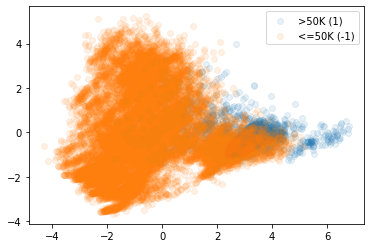

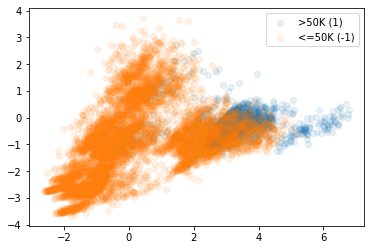

In [540]:
def printer(point, columns, le_dict):
  for column in point.columns:
    if is_dummy(column):
      feature, category = decode_ohe(column)
      if feature in columns:
        if (point[column] == 1).values[0]:
          print(f"{feature}: {category}")
    elif column in columns:
      if column in le_dict:
        le = le_dict[column]
        index = np.array(point[column]).astype(np.int)
        value = le.inverse_transform(index)[0]
        print(f"{column}: {value}")
      else:
        print(f"{column}: {point[column].values[0]}")


df_X, df_Y, df_test_X, df_test_Y, le = load_data()

X = np.array(X)
Y = np.array(Y)

immutable_columns = ['age', 'sex', 'race'] #, 'relationship', 'marital-status']
column_tolerances = {'age': 5}
actionability_filter = get_actionability_filter(df_X, immutable_columns, column_tolerances)
full_columns = immutable_columns_full(df_X, immutable_columns)

poi_df, _, _ = df_sample(df_X, df_Y, -1)
poi = np.array(poi_df)[0]

printme = (poi_df * std + mean).loc[:,full_columns]
print("POI:")
printer(printme, immutable_columns, le)

Xnew, Ynew = actionability_filter(X, Y, poi)
print("-"*20)
print(f"Removed {X.shape[0] - Xnew.shape[0]} out of {X.shape[0]} points. {Xnew.shape[0]} points remain.")

pca = PCA(2)
pca.fit(X)

display_scatter(pca.transform(X), Y, alpha=0.1)

X_filtered_pca = pca.transform(Xnew)
display_scatter(X_filtered_pca, Ynew, alpha=0.1)

## Run Experiment

TODO:
1. Print out some recourse
2. Implement early stopping
3. Implement the rest of the experimentation results
4. Clean up the whole file
5. Do a write up in overleaf?
6. Instead of crashing, output statistics on failure rate

Filter points for accuracy...
Culled 6779 out of 27134 points


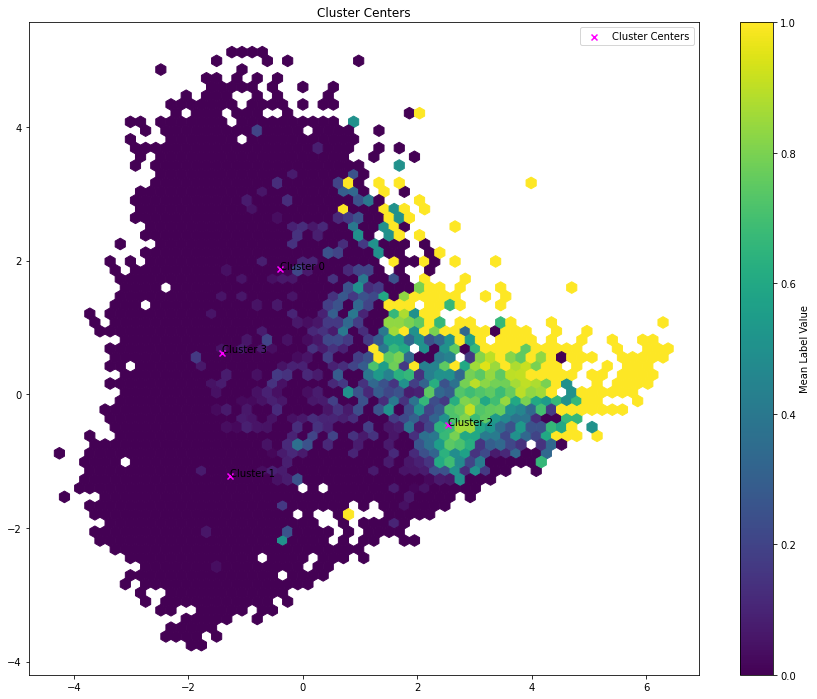

Running experiment...
n=0
n=1
n=2
n=3
n=4
n=5
n=6
n=7
n=8
n=9
   Direction-id  Converged  Path-Length  Positive-Prob  Actionable  Valid
0             0        1.0         35.0       0.772939         1.0    1.0
1             1        1.0         35.0       0.786309         1.0    1.0
2             2        1.0         35.0       0.694897         1.0    1.0
3             3        1.0         35.0       0.786272         1.0    1.0


In [75]:
#print("Loading data...")
#df_X, df_Y, df_test_X, df_test_Y, le_dict = load_data()

#print("Training a classifier...")
#rf, accuracy = train_random_forest(df_X, df_Y, df_test_X, df_test_Y)
#print(f"Accuracy is {accuracy}")

print("Filter points for accuracy...")
X, Y = filter_accuracy(df_X, df_Y, rf, certainty_cutoff=0.65)
print(f"Culled {df_X.shape[0] - X.shape[0]} out of {df_X.shape[0]} points")

do_filtering = True
actionability_filter = None
diff_function = None
if do_filtering:
  # Create filter for actionability
  immutable_columns = ['sex', 'age'] #, 'age', 'relationship', 'marital-status']
  column_tolerances = {'age': 10}
  actionability_filter = get_actionability_filter(df_X, immutable_columns, column_tolerances)

  # Create difference function to zero-out influence of remaining immutable features
  immutable_columns = ['age'] #, 'relationship', 'marital-status']
  diff_function = make_immutable_dist(df_X, immutable_columns, mask_value=0)
  diff_function = None

X = np.array(X)
Y = np.array(Y)

alpha = lambda dist: cliff_alpha(dist, cutoff=0.5, degree=2)
alpha_neg = lambda dist: cliff_alpha(dist, cutoff=0.5, degree=5)

mrm = MRM(alpha=alpha, alpha_neg=alpha_neg, ignore_negatives=True, difference_function=diff_function)
n_clusters = 4
clusterer = KMeans(n_clusters=n_clusters)
clusterer.fit(X)
early_stopping = None
mrmc = MRMCIterator(clusterer, n_clusters, mrm, perturb_dir=constant_step_size, max_iterations=35)

display_heatmap(X, Y, clusters=clusterer.cluster_centers_, title="Cluster Centers", do_pca=True, size='large')

print("Running experiment...")
results = run_experiment(X, Y, mrmc, rf, N=10, filter_points=actionability_filter)
print(results)